In [154]:
import importlib
import segmentation.segment_utils as seg_utils

importlib.reload(seg_utils)

import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import sys
from skimage.segmentation import felzenszwalb

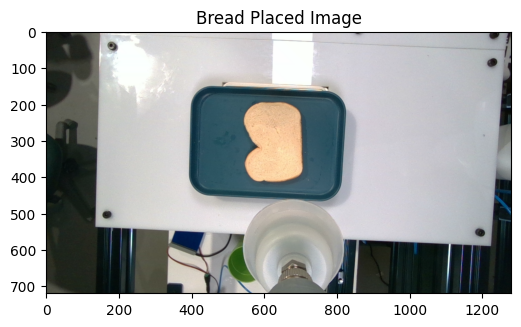

Number of contours detected: 12
Number of filtered contours (potential trays): 1
Number of filtered contours (potential bread slices): 1


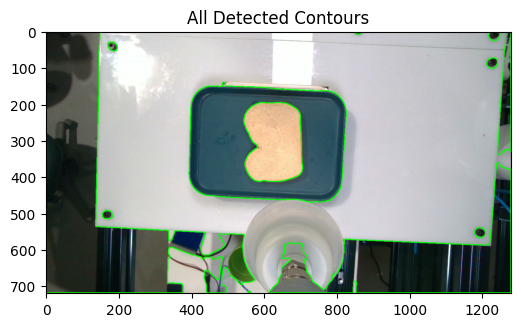

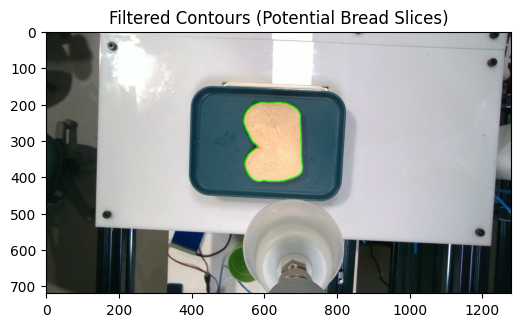

Bread slice is placed on the tray!


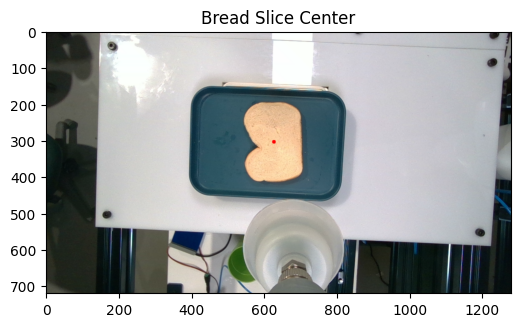

In [47]:
# STEP 1: BREAD PLACED AND ARM MOVED TO CHECK POSITION - Capture Image from here

# Load bread image
bread_place_image = cv2.imread(
    "/Users/abhi/Documents/CMU/2024-25/Projects/SNAAK/Vision/sandwich_check_data/cheese_ham_assembly/image_20250323-162330.png"
)

# show image
plt.figure(figsize=(6, 6))
plt.title("Bread Placed Image")
plt.imshow(cv2.cvtColor(bread_place_image, cv2.COLOR_BGR2RGB))
plt.show()

# STEP 2: CHECK BREAD PLACEMENT ON TRAY 

# get all contours from placed image
# contours, hierarchy = seg_utils.contour_segmentation(bread_place_image, show_image=True, show_steps=True, segment_type="edges", show_separate_contours=False, edges_thresholds=(30, 50))
contours, hierarchy = seg_utils.contour_segmentation(bread_place_image, show_image=True, segment_type='binary')

# NOTE: to classify contours, several features can be used such as:
        # shape, area, color, etc.
        # using area for now

# get tray contour indices by area
min_tray_area = 125000  # Minimum area threshold for the tray
max_tray_area = 127000  # Maximum area threshold for the tray
tray_contour_indices = [
    i for i, cnt in enumerate(contours) if min_tray_area < cv2.contourArea(cnt) < max_tray_area
]
print(f"Number of filtered contours (potential trays): {len(tray_contour_indices)}")

# Visualize Filtered Tray Contours
# contour_image_filtered = bread_place_image.copy()
# cv2.drawContours(
#     contour_image_filtered, [contours[i] for i in tray_contour_indices], -1, (0, 255, 0), thickness=2
# )
# plt.figure(figsize=(6, 6))
# plt.title("Filtered Contours (Potential Trays)")
# plt.imshow(cv2.cvtColor(contour_image_filtered, cv2.COLOR_BGR2RGB))
# plt.show()

# get bread contour indices by area
min_bread_area = 27000  # Minimum area threshold for the bread slice
max_bread_area = 38000  # Maximum area threshold for the bread slice
bread_contour_indices = [
    i for i, cnt in enumerate(contours) if min_bread_area < cv2.contourArea(cnt) < max_bread_area
]
print(f"Number of filtered contours (potential bread slices): {len(bread_contour_indices)}")

# Visualize Filtered Bread Contours
contour_image_filtered = bread_place_image.copy()
cv2.drawContours(
    contour_image_filtered, [contours[i] for i in bread_contour_indices], -1, (0, 255, 0), thickness=2
)
plt.figure(figsize=(6, 6))
plt.title("Filtered Contours (Potential Bread Slices)")
plt.imshow(cv2.cvtColor(contour_image_filtered, cv2.COLOR_BGR2RGB))
plt.show()

# check if bread is placed on tray
bread_on_tray = False

# does the bread slice contour fall completely inside the tray contour?
for tray_index in tray_contour_indices:
    for bread_index in bread_contour_indices:
        if hierarchy[0][bread_index][3] == tray_index:
            bread_on_tray = True
            break
    if bread_on_tray:
        break

if not bread_on_tray:
    print("Bread slice is not placed on the tray.")
    sys.exit(1)
else:
    print("Bread slice is placed on the tray!")
    
# get center of the bread slice
bread_contour = contours[bread_contour_indices[0]]
M = cv2.moments(bread_contour)
if M["m00"] != 0:
    cx = int(M["m10"] / M["m00"])
    cy = int(M["m01"] / M["m00"])
else:
    cx, cy = 0, 0
    
# draw center of bread slice
bread_place_image_with_center = bread_place_image.copy()
cv2.circle(bread_place_image_with_center, (cx, cy), 5, (0, 0, 255), -1)
plt.figure(figsize=(6, 6))
plt.title("Bread Slice Center")
plt.imshow(cv2.cvtColor(bread_place_image_with_center, cv2.COLOR_BGR2RGB))
plt.show()

# extract a box of pixels around the center of the bread slice
# box_size = 25  # size of the box
# x1 = max(0, cx - box_size)
# x2 = min(bread_place_image.shape[1], cx + box_size)
# y1 = max(0, cy - box_size)
# y2 = min(bread_place_image.shape[0], cy + box_size)
# bread_slice_box = bread_place_image[y1:y2, x1:x2]
# # # show bread slice box
# # plt.figure(figsize=(6, 6))
# # plt.title("Bread Slice Box")
# # plt.imshow(cv2.cvtColor(bread_slice_box, cv2.COLOR_BGR2RGB))
# # plt.show()
# # get hsv range for bread slice box
# bread_box_hsv_range = seg_utils.get_hsv_range(bread_slice_box)
# print(f"bread slice box hsv range: {bread_box_hsv_range}")


    
# # extract the bread slice contour
# bread_contour = contours[bread_contour_indices[0]]
# # create mask for bread slice
# bread_mask = np.zeros(bread_place_image.shape[:2], dtype=np.uint8)
# # fill the bread slice contour on the mask
# cv2.drawContours(bread_mask, [bread_contour], -1, 255, thickness=cv2.FILLED)
# # apply mask to the image
# bread_slice_image = cv2.bitwise_and(bread_place_image, bread_place_image, mask=bread_mask)
# # print(f"shape of bread slice image: {bread_slice_image.shape}")
# # print(f"center of bread slice image: {bread_slice_image[0, 0]}")

# # # show bread slice image
# # plt.figure(figsize=(6, 6))
# # plt.title("Bread Slice Image")
# # plt.imshow(cv2.cvtColor(bread_slice_image, cv2.COLOR_BGR2RGB))
# # plt.show()

# # get hsv range for bread slice
# bread_hsv_range = seg_utils.get_hsv_range_from_image(bread_slice_image)
# print(f"bread hsv range: {bread_hsv_range}")

# # visualize bread slice using hsv range
# bread_hsv_image = seg_utils.segment_from_hsv(bread_place_image, bread_hsv_range[0], bread_hsv_range[1])
# plt.figure(figsize=(6, 6))
# plt.title("Bread Slice Image using HSV Range from Image")
# plt.imshow(cv2.cvtColor(bread_hsv_image, cv2.COLOR_BGR2RGB))
# plt.show()

# # visualize bread slice using hsv range
# bread_hsv_image = seg_utils.segment_from_hsv(bread_place_image, bread_box_hsv_range[0], bread_box_hsv_range[1])
# plt.figure(figsize=(6, 6))
# plt.title("Bread Slice Image using HSV Range from Box")
# plt.imshow(cv2.cvtColor(bread_hsv_image, cv2.COLOR_BGR2RGB))
# plt.show()




  

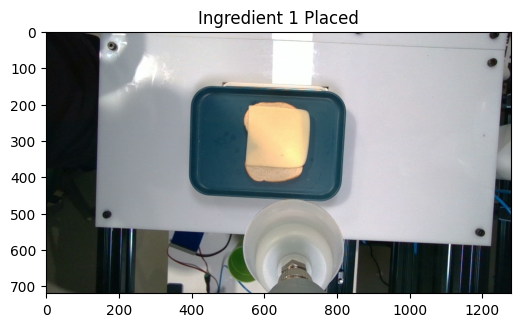

Number of contours detected: 1973
Number of filtered contours (potential cheese slices): 1


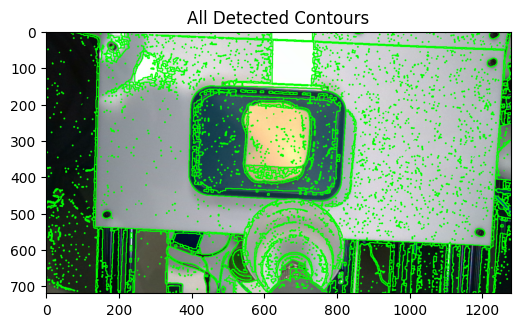

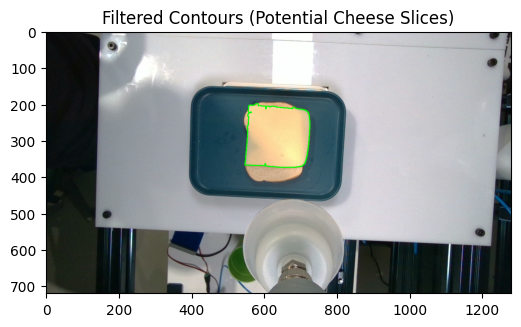

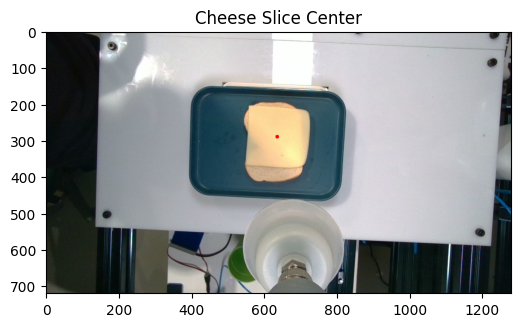

Distance between bread slice and cheese slice centers: [np.float64(0.0)]


In [ ]:
# STEP 4: PLACE CHEESE ON BREAD SLICE    

# Load ingredient placed image
ingredient_place_image = cv2.imread(
    "/Users/abhi/Documents/CMU/2024-25/Projects/SNAAK/Vision/sandwich_check_data/cheese_ham_assembly/image_20250323-162333.png"
)

# show image
plt.figure(figsize=(6, 6))
plt.title("Ingredient 1 Placed")
plt.imshow(cv2.cvtColor(ingredient_place_image, cv2.COLOR_BGR2RGB))
plt.show()

# # visualize bread slice using hsv range
# bread_hsv_image = seg_utils.segment_from_hsv(ingredient_place_image, bread_box_hsv_range[0], bread_box_hsv_range[1])
# plt.figure(figsize=(6, 6))
# plt.title("Bread Slice Image using HSV Range from Box")
# plt.imshow(cv2.cvtColor(bread_hsv_image, cv2.COLOR_BGR2RGB))
# plt.show()

# # STEP 4: CHECK INGREDIENT PLACEMENT ON BREAD SLICE

# # get pixels of interest using difference mask
# diff_mask = seg_utils.difference_mask(bread_place_image, ingredient_place_image, thresh=18) 
# # need to tune the "difference threshold" accordingly (10-20 seems to work well for now)

# # add mask to ingredient placed image to highlight changed pixels
# roi_pixels_image = cv2.bitwise_and(
#     ingredient_place_image, ingredient_place_image, mask=diff_mask
# )

# plt.figure(figsize=(6, 6))
# plt.title("Difference Mask - Ingredient 1")
# plt.imshow(cv2.cvtColor(roi_pixels_image, cv2.COLOR_BGR2RGB))
# plt.show()

# # get contrours from diff mask using binary segmentation
# contours, hierarchy = seg_utils.contour_segmentation(roi_pixels_image, show_image=False, segment_type='binary', show_steps=False, binary_threshold=150)


# # visualize binary difference mask
# plt.figure(figsize=(6, 6))
# plt.title("Binary Difference Mask - Ingredient 1")
# plt.imshow(binary_diff_mask, cmap="gray")
# plt.show()


# get contours from diff mask using edge segmentation
contours, hierarchy = seg_utils.contour_segmentation(ingredient_place_image, show_image=True, show_steps=False, segment_type="edges", show_separate_contours=False, edges_thresholds=(30, 50))

# filter cheese contours by area (to isolate the cheese slice)
min_area = 25000  # Minimum area threshold for the cheese slice
max_area = 28000  # Maximum area threshold for the cheese slice
filtered_contours = [cnt for cnt in contours if min_area < cv2.contourArea(cnt) < max_area]
print(f"Number of filtered contours (potential cheese slices): {len(filtered_contours)}")
# Visualize Filtered Contours
contour_image_filtered = ingredient_place_image.copy()
cv2.drawContours(contour_image_filtered, filtered_contours, -1, (0, 255, 0), thickness=2)

# visualize filtered contours
plt.figure(figsize=(6, 6))
plt.title("Filtered Contours (Potential Cheese Slices)")
plt.imshow(cv2.cvtColor(contour_image_filtered, cv2.COLOR_BGR2RGB))
plt.show()


# CHECK 1: calculate overlap between bread and cheese slices as percentage of cheese slice area
# bread_cheese_overlap = 0

# get cheese slice contour pixels
# cheese_contour_pixels = np.zeros_like(ingredient_place_image)
# cv2.drawContours(cheese_contour_pixels, filtered_contours, -1, (255), thickness=cv2.FILLED)

# # calculate overlap
# # NOTE: The bread is not a rectangle, so the overlap currently computes the raw pixel overlap - improve this by fitting a rectangle around the bread slice?
# overlap_pixels = cv2.bitwise_and(bread_contour_pixels, cheese_contour_pixels)

# # visualize overlap
# # plt.figure(figsize=(6, 6))
# # plt.title("Overlap between Bread and Cheese Slices")
# # plt.imshow(overlap_pixels, cmap="gray")
# # plt.show()

# # calculate overlap as percentage of cheese slice area
# cheese_area = cv2.contourArea(filtered_contours[0])
# overlap_area = np.count_nonzero(overlap_pixels)
# bread_cheese_overlap = (overlap_area / cheese_area) * 100

# CHECK 2: check euclidean distance between cheese slice and bread slice center
# get cheese slice center
cheese_slice_center = []
for cnt in filtered_contours:
    M = cv2.moments(cnt)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        cheese_slice_center.append((cx, cy))
        
# draw center of cheese slice
ingredient_place_image_with_center = ingredient_place_image.copy()
for center in cheese_slice_center:
    cv2.circle(ingredient_place_image_with_center, center, 5, (0, 0, 255), -1)
plt.figure(figsize=(6, 6))
plt.title("Cheese Slice Center")
plt.imshow(cv2.cvtColor(ingredient_place_image_with_center, cv2.COLOR_BGR2RGB))
plt.show()

# calculate euclidean distance between cheese slice center and bread slice center
bread_cheese_distance = []
for center in cheese_slice_center:
    distance = np.sqrt((cx - center[0]) ** 2 + (cy - center[1]) ** 2)
    bread_cheese_distance.append(distance)
print(f"Distance between bread slice and cheese slice centers: {bread_cheese_distance}")


prev_placement_scene = ingredient_place_image.copy()




# 

In [ ]:
# To threshold image by HSV values and see the results
def nothing(x):
    pass

# Load the image
image = cv2.imread("/Users/abhi/Documents/CMU/2024-25/Projects/SNAAK/Vision/sandwich_check_data/cheese_assembly/image_20250323-161850.png")
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Create a window
cv2.namedWindow("HSV Tuning")

# Create trackbars for lower and upper HSV ranges
cv2.createTrackbar("Lower H", "HSV Tuning", 0, 179, nothing)
cv2.createTrackbar("Lower S", "HSV Tuning", 0, 255, nothing)
cv2.createTrackbar("Lower V", "HSV Tuning", 0, 255, nothing)
cv2.createTrackbar("Upper H", "HSV Tuning", 179, 179, nothing)
cv2.createTrackbar("Upper S", "HSV Tuning", 255, 255, nothing)
cv2.createTrackbar("Upper V", "HSV Tuning", 255, 255, nothing)

while True:
    # Get current positions of trackbars
    lower_h = cv2.getTrackbarPos("Lower H", "HSV Tuning")
    lower_s = cv2.getTrackbarPos("Lower S", "HSV Tuning")
    lower_v = cv2.getTrackbarPos("Lower V", "HSV Tuning")
    upper_h = cv2.getTrackbarPos("Upper H", "HSV Tuning")
    upper_s = cv2.getTrackbarPos("Upper S", "HSV Tuning")
    upper_v = cv2.getTrackbarPos("Upper V", "HSV Tuning")

    # Define lower and upper HSV range
    lower_hsv = np.array([lower_h, lower_s, lower_v])
    upper_hsv = np.array([upper_h, upper_s, upper_v])

    # Threshold the HSV image to get only the desired colors
    mask = cv2.inRange(hsv_image, lower_hsv, upper_hsv)

    # Apply the mask to the original image
    result = cv2.bitwise_and(image, image, mask=mask)

    # Show the original image, mask, and result
    cv2.imshow("Original Image", image)
    cv2.imshow("Mask", mask)
    cv2.imshow("Result", result)

    # Break the loop when a key
    if cv2.waitKey(1):
        break

cv2.destroyAllWindows()

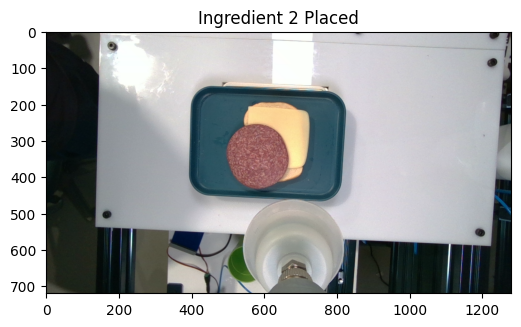

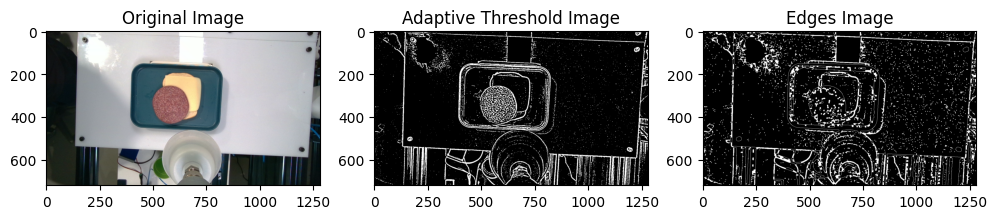

Number of contours detected: 2097
Number of filtered contours (potential ham slices): 1


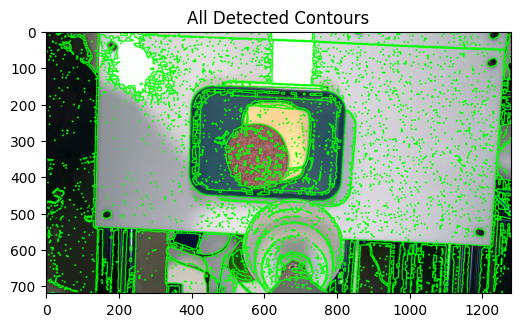

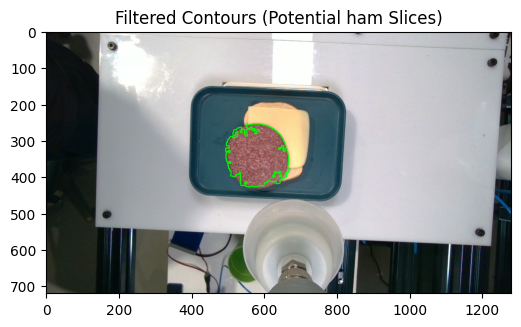

In [ ]:
# STEP 6: PLACE HAM ON CHEESE ON BREAD

ingredient_place_image = cv2.imread("/Users/abhi/Documents/CMU/2024-25/Projects/SNAAK/Vision/sandwich_check_data/cheese_ham_assembly/image_20250323-162337.png")

# show image
plt.figure(figsize=(6, 6))
plt.title("Ingredient 2 Placed")
plt.imshow(cv2.cvtColor(ingredient_place_image, cv2.COLOR_BGR2RGB))
plt.show()

# # get difference mask
# diff_mask = seg_utils.difference_mask(
#     prev_placement_scene, ingredient_place_image, thresh=8
# ) 
# # need to tune the "difference threshold" accordingly (10-20 seems to work well for now)

# # # add mask to ingredient placed image to highlight changed pixels
# changed_pixels_image = cv2.bitwise_and(
#     ingredient_place_image, ingredient_place_image, mask=diff_mask
# )

# plt.figure(figsize=(6, 6))
# plt.title("Difference Mask - Ingredient 2")
# plt.imshow(cv2.cvtColor(changed_pixels_image, cv2.COLOR_BGR2RGB))
# plt.show()

# get contours using edges
contours, hierarchy = seg_utils.contour_segmentation(ingredient_place_image, show_image=True, show_steps=True, segment_type="edges", edges_thresholds=(30, 50), show_separate_contours=False)


# filter ham contours by area (to isolate the ham slice)
min_area = 22000  # Minimum area threshold for the ham slice
max_area = 23000  # Maximum area threshold for the ham slice
filtered_contours = [cnt for cnt in contours if min_area < cv2.contourArea(cnt) < max_area]
print(f"Number of filtered contours (potential ham slices): {len(filtered_contours)}")
# Visualize Filtered Contours
contour_image_filtered = ingredient_place_image.copy()
cv2.drawContours(contour_image_filtered, filtered_contours, -1, (0, 255, 0), thickness=2)

# visualize filtered contours
plt.figure(figsize=(6, 6))
plt.title("Filtered Contours (Potential ham Slices)")
plt.imshow(cv2.cvtColor(contour_image_filtered, cv2.COLOR_BGR2RGB))
plt.show()

In [83]:
# STEP 7: PLACE CHEESE ON CHEESE ON BREAD


# load all images in the directory

load_directory = "/Users/abhi/Documents/CMU/2024-25/Projects/SNAAK/Vision/sandwich_check_data/cheese_assembly/"
save_directory = "/Users/abhi/Documents/CMU/2024-25/Projects/SNAAK/Vision/sandwich_check_data/cheese_assembly/top_cheese/"

import os
import glob

# Get a list of all image files in the directory
image_files = glob.glob(os.path.join(load_directory, "*.png"))
# Sort the image files by name
image_files.sort()
# Print the sorted list of image files
for image_file in image_files:
    
    #load image
    image = cv2.imread(image_file)
    
    # # show image
    # plt.figure(figsize=(6, 6))
    # plt.title("Ingredient 2 Placed")
    # plt.imshow(cv2.cvtColor(ingredient_place_image, cv2.COLOR_BGR2RGB))
    # plt.show()

    # apply edge segmentation
    contours, hierarchy = seg_utils.contour_segmentation(image, show_image=False, show_steps=False, segment_type="edges", edges_thresholds=(30, 50), show_separate_contours=False)

    # get top cheese contours by area
    min_area = 22000  # Minimum area threshold for the cheese slice
    max_area = 34000  # Maximum area threshold for the cheese slice
    filtered_contours = [cnt for cnt in contours if min_area < cv2.contourArea(cnt) < max_area]
    print(f"Number of filtered contours (potential cheese slices): {len(filtered_contours)}")
    # Visualize Filtered Contours
    contour_image_filtered = image.copy()
    cv2.drawContours(contour_image_filtered, filtered_contours, -1, (0, 255, 0), thickness=2)
    # visualize filtered contours
    # plt.figure(figsize=(6, 6))
    # plt.title("Filtered Contours (Potential cheese Slices)")
    # plt.imshow(cv2.cvtColor(contour_image_filtered, cv2.COLOR_BGR2RGB))
    # plt.show()
    
    # save new image with contours
    # create the save directory if it doesn't exist
    os.makedirs(save_directory, exist_ok=True)
    # get the filename from the image path
    filename = os.path.basename(image_file)
    # create the full path for the new image
    image_file = os.path.join(save_directory, filename)
    # save the new image
    cv2.imwrite(image_file, contour_image_filtered)
    print(f"Saved image: {image_file}")


Number of contours detected: 2352
Number of filtered contours (potential cheese slices): 0
Saved image: /Users/abhi/Documents/CMU/2024-25/Projects/SNAAK/Vision/sandwich_check_data/cheese_assembly/top_cheese/image_20250323-161448.png
Number of contours detected: 2352
Number of filtered contours (potential cheese slices): 1
Saved image: /Users/abhi/Documents/CMU/2024-25/Projects/SNAAK/Vision/sandwich_check_data/cheese_assembly/top_cheese/image_20250323-161501.png
Number of contours detected: 2321
Number of filtered contours (potential cheese slices): 1
Saved image: /Users/abhi/Documents/CMU/2024-25/Projects/SNAAK/Vision/sandwich_check_data/cheese_assembly/top_cheese/image_20250323-161557.png
Number of contours detected: 2368
Number of filtered contours (potential cheese slices): 1
Saved image: /Users/abhi/Documents/CMU/2024-25/Projects/SNAAK/Vision/sandwich_check_data/cheese_assembly/top_cheese/image_20250323-161614.png
Number of contours detected: 2312
Number of filtered contours (poten

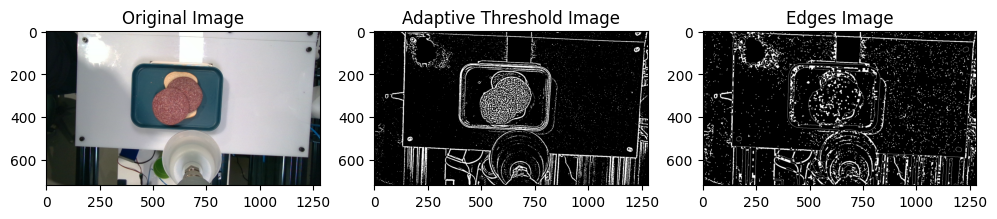

Number of contours detected: 2085
Contour 0: Area = 1.0
Contour 1: Area = 3.5
Contour 2: Area = 5.0
Contour 3: Area = 5.0
Contour 4: Area = 5.5
Contour 5: Area = 0.5
Contour 6: Area = 8.0
Contour 7: Area = 0.0
Contour 8: Area = 4.0
Contour 9: Area = 13.0
Contour 10: Area = 8.5
Contour 11: Area = 1.0
Contour 12: Area = 19.0
Contour 13: Area = 4.0
Contour 14: Area = 15.5
Contour 15: Area = 4.0
Contour 16: Area = 7.5
Contour 17: Area = 4.0
Contour 18: Area = 0.5
Contour 19: Area = 9.0
Contour 20: Area = 4.0
Contour 21: Area = 4.0
Contour 22: Area = 3.5
Contour 23: Area = 3.0
Contour 24: Area = 16.0
Contour 25: Area = 4.5
Contour 26: Area = 0.5
Contour 27: Area = 106.5
Contour 28: Area = 75.0
Contour 29: Area = 6.0
Contour 30: Area = 3.5
Contour 31: Area = 0.0
Contour 32: Area = 61.5
Contour 33: Area = 16.0
Contour 34: Area = 42.0
Contour 35: Area = 175.0
Contour 36: Area = 4.0
Contour 37: Area = 4.0
Contour 38: Area = 16.5
Contour 39: Area = 21.5
Contour 40: Area = 8.5
Contour 41: Area = 

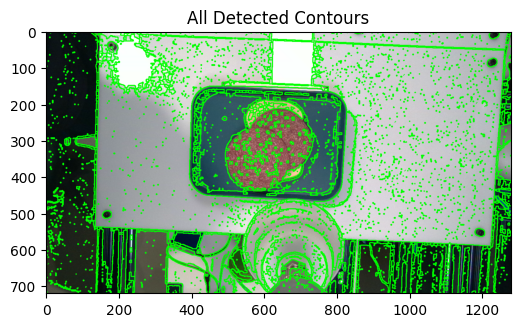

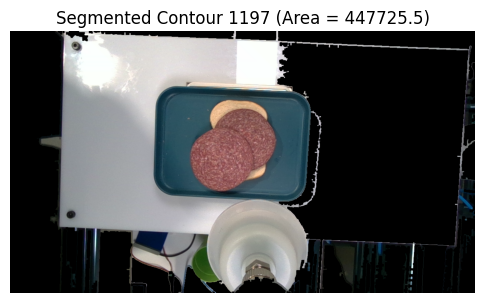

Contour 1198: Area = 34.0
Contour 1199: Area = 58.0
Contour 1200: Area = 156.0
Contour 1201: Area = 40.0
Contour 1202: Area = 81.0
Contour 1203: Area = 34.0
Contour 1204: Area = 175.0
Contour 1205: Area = 34.0
Contour 1206: Area = 88.0
Contour 1207: Area = 78.0
Contour 1208: Area = 46.0
Contour 1209: Area = 40.0
Contour 1210: Area = 216.5
Contour 1211: Area = 46.0
Contour 1212: Area = 59.5
Contour 1213: Area = 34.0
Contour 1214: Area = 58.0
Contour 1215: Area = 109.5
Contour 1216: Area = 582.0
Contour 1217: Area = 629.0
Contour 1218: Area = 76.0
Contour 1219: Area = 34.0
Contour 1220: Area = 70.0
Contour 1221: Area = 34.0
Contour 1222: Area = 46.0
Contour 1223: Area = 112.0
Contour 1224: Area = 40.0
Contour 1225: Area = 77.0
Contour 1226: Area = 305.0
Contour 1227: Area = 1187.5
Contour 1228: Area = 22.5
Contour 1229: Area = 40.0
Contour 1230: Area = 70.0
Contour 1231: Area = 96.0
Contour 1232: Area = 64.0
Contour 1233: Area = 51.0
Contour 1234: Area = 1569.0
Contour 1235: Area = 52.0


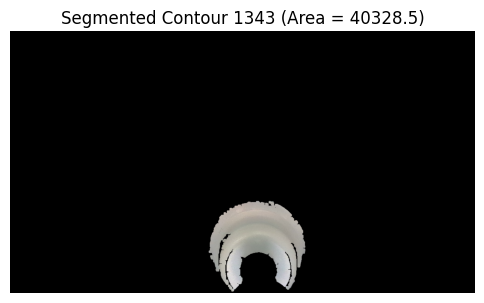

Contour 1344: Area = 4.0
Contour 1345: Area = 4.0
Contour 1346: Area = 72.5
Contour 1347: Area = 8.5
Contour 1348: Area = 20.5
Contour 1349: Area = 4.0
Contour 1350: Area = 3.5
Contour 1351: Area = 2.5
Contour 1352: Area = 4.0
Contour 1353: Area = 202.5
Contour 1354: Area = 77.5
Contour 1355: Area = 4.0
Contour 1356: Area = 0.5
Contour 1357: Area = 37.5
Contour 1358: Area = 0.5
Contour 1359: Area = 3.0
Contour 1360: Area = 0.0
Contour 1361: Area = 37.0
Contour 1362: Area = 33.5
Contour 1363: Area = 0.0
Contour 1364: Area = 4.0
Contour 1365: Area = 11.0
Contour 1366: Area = 11.5
Contour 1367: Area = 9.0
Contour 1368: Area = 3.0
Contour 1369: Area = 49.5
Contour 1370: Area = 15.5
Contour 1371: Area = 4.0
Contour 1372: Area = 3.5
Contour 1373: Area = 1.0
Contour 1374: Area = 3.0
Contour 1375: Area = 4.0
Contour 1376: Area = 30.0
Contour 1377: Area = 13.0
Contour 1378: Area = 4.0
Contour 1379: Area = 4.0
Contour 1380: Area = 4.0
Contour 1381: Area = 4.0
Contour 1382: Area = 3.0
Contour 138

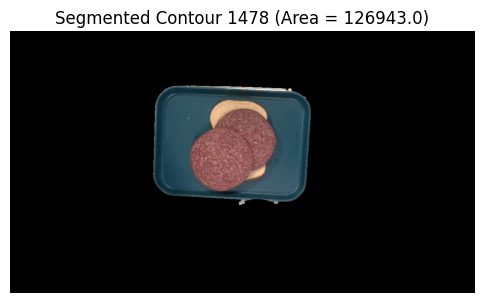

Contour 1479: Area = 0.0
Contour 1480: Area = 4.0
Contour 1481: Area = 11.5
Contour 1482: Area = 4.0
Contour 1483: Area = 4.0
Contour 1484: Area = 4.0
Contour 1485: Area = 4.0
Contour 1486: Area = 7.0
Contour 1487: Area = 9.0
Contour 1488: Area = 27.0
Contour 1489: Area = 4.0
Contour 1490: Area = 3.5
Contour 1491: Area = 0.5
Contour 1492: Area = 0.5
Contour 1493: Area = 33.0
Contour 1494: Area = 3.5
Contour 1495: Area = 4.0
Contour 1496: Area = 23.5
Contour 1497: Area = 22.0
Contour 1498: Area = 27.0
Contour 1499: Area = 29.0
Contour 1500: Area = 25.5
Contour 1501: Area = 22.0
Contour 1502: Area = 27.0
Contour 1503: Area = 12.0
Contour 1504: Area = 16.0
Contour 1505: Area = 4.0
Contour 1506: Area = 188.0
Contour 1507: Area = 11.0
Contour 1508: Area = 44.5
Contour 1509: Area = 34.0
Contour 1510: Area = 0.0
Contour 1511: Area = 0.0
Contour 1512: Area = 283.5
Contour 1513: Area = 40.0
Contour 1514: Area = 40.0
Contour 1515: Area = 27.0
Contour 1516: Area = 22.5
Contour 1517: Area = 27.0
C

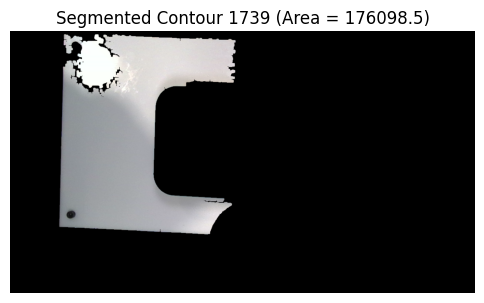

Contour 1740: Area = 0.5
Contour 1741: Area = 4.0
Contour 1742: Area = 4.0
Contour 1743: Area = 8.5
Contour 1744: Area = 0.0
Contour 1745: Area = 4.0
Contour 1746: Area = 3.0
Contour 1747: Area = 4.0
Contour 1748: Area = 11.0
Contour 1749: Area = 4.0
Contour 1750: Area = 4.0
Contour 1751: Area = 4.0
Contour 1752: Area = 3.0
Contour 1753: Area = 4.0
Contour 1754: Area = 4.0
Contour 1755: Area = 4.0
Contour 1756: Area = 3.5
Contour 1757: Area = 3.0
Contour 1758: Area = 4.0
Contour 1759: Area = 5.0
Contour 1760: Area = 6.0
Contour 1761: Area = 16.0
Contour 1762: Area = 4.0
Contour 1763: Area = 15.0
Contour 1764: Area = 0.5
Contour 1765: Area = 4.0
Contour 1766: Area = 0.0
Contour 1767: Area = 3.0
Contour 1768: Area = 4.0
Contour 1769: Area = 3.0
Contour 1770: Area = 3.0
Contour 1771: Area = 3.0
Contour 1772: Area = 4.0
Contour 1773: Area = 4.0
Contour 1774: Area = 406.0
Contour 1775: Area = 394.0
Contour 1776: Area = 2.5
Contour 1777: Area = 3.0
Contour 1778: Area = 22.5
Contour 1779: Are

array([[[21, 16, 11],
        [19, 14,  9],
        [19, 14,  9],
        ...,
        [63, 56, 58],
        [61, 57, 57],
        [59, 55, 55]],

       [[21, 14,  9],
        [23, 16, 11],
        [23, 16, 11],
        ...,
        [64, 57, 58],
        [61, 57, 57],
        [61, 57, 57]],

       [[19, 14,  9],
        [21, 16, 11],
        [22, 17, 12],
        ...,
        [64, 57, 58],
        [60, 58, 58],
        [59, 57, 57]],

       ...,

       [[69, 82, 81],
        [68, 81, 80],
        [65, 78, 77],
        ...,
        [15, 13,  7],
        [15, 13,  7],
        [16, 14,  8]],

       [[69, 82, 80],
        [69, 82, 80],
        [68, 81, 79],
        ...,
        [16, 14,  8],
        [16, 14,  8],
        [16, 14,  8]],

       [[69, 82, 80],
        [69, 82, 80],
        [70, 83, 81],
        ...,
        [16, 14,  8],
        [16, 14,  8],
        [16, 14,  8]]], shape=(720, 1280, 3), dtype=uint8)

In [ ]:
# STEP 7: PLACE HAM ON HAM ON BREAD


# load all images in the directory

load_directory = "/Users/abhi/Documents/CMU/2024-25/Projects/SNAAK/Vision/sandwich_check_data/ham_assembly/"
save_directory = "/Users/abhi/Documents/CMU/2024-25/Projects/SNAAK/Vision/sandwich_check_data/ham_assembly/top_ham/"

import os
import glob

# # Get a list of all image files in the directory
# image_files = glob.glob(os.path.join(load_directory, "*.png"))
# # Sort the image files by name
# image_files.sort()
# # Print the sorted list of image files
# for image_file in image_files:
    
#load image
image_file = "/Users/abhi/Documents/CMU/2024-25/Projects/SNAAK/Vision/sandwich_check_data/ham_assembly/top_ham/failure/image_20250323-162127.png"
image = cv2.imread(image_file)

# # show image
# plt.figure(figsize=(6, 6))
# plt.title("Ingredient 2 Placed")
# plt.imshow(cv2.cvtColor(ingredient_place_image, cv2.COLOR_BGR2RGB))
# plt.show()

# apply edge segmentation
contours, hierarchy = seg_utils.contour_segmentation(image, show_image=True, show_steps=True, segment_type="edges", edges_thresholds=(30, 50), show_separate_contours=True)

# wait for key press

# get top cheese contours by area
min_area = 21000  # Minimum area threshold for the cheese slice
max_area = 25000  # Maximum area threshold for the cheese slice
filtered_contours = [cnt for cnt in contours if min_area < cv2.contourArea(cnt) < max_area]
print(f"Number of filtered contours (potential ham slices): {len(filtered_contours)}")
# # Visualize Filtered Contours
contour_image_filtered = image.copy()
cv2.drawContours(contour_image_filtered, filtered_contours, -1, (0, 255, 0), thickness=2)
# # visualize filtered contours
# plt.figure(figsize=(6, 6))
# plt.title("Filtered Contours (Potential cheese Slices)")
# plt.imshow(cv2.cvtColor(contour_image_filtered, cv2.COLOR_BGR2RGB))
# plt.show()

# save new image with contours
# create the save directory if it doesn't exist
# os.makedirs(save_directory, exist_ok=True)
# # get the filename from the image path
# filename = os.path.basename(image_file)
# # create the full path for the new image
# image_file = os.path.join(save_directory, filename)
# # save the new image
# cv2.imwrite(image_file, contour_image_filtered)
# print(f"Saved image: {image_file}")

#DOES NOT WORK FOR ALL HAM IMAGES


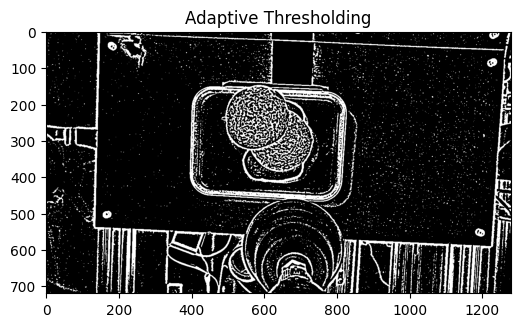

In [ ]:
# HAM ON BREAD - 2


#load image
image_file = "/Users/abhi/Documents/CMU/2024-25/Projects/SNAAK/Vision/sandwich_check_data/ham_assembly/image_20250323-162129.png"
image = cv2.imread(image_file)

original_image = image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Step 1: Preprocessing (Gaussian Blur)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Step 2: Adaptive Thresholding with Reduced Sensitivity
adaptive_thresh = cv2.adaptiveThreshold(
    blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 15, 2
)

# show adaptive thresholding
plt.figure(figsize=(6, 6))
plt.title("Adaptive Thresholding")
plt.imshow(cv2.cvtColor(adaptive_thresh, cv2.COLOR_BGR2RGB))
plt.show()
# # Step 2: Morphological Operations to Remove Noise



In [ ]:
# CHEESE AND HAM ASSEMBLY

# load all images in the directory
load_directory = "/Users/abhi/Documents/CMU/2024-25/Projects/SNAAK/Vision/sandwich_check_data/full_sw_assembly/"
save_directory = "/Users/abhi/Documents/CMU/2024-25/Projects/SNAAK/Vision/sandwich_check_data/full_sw_assembly/top_ingredient/"


image_files = glob.glob(os.path.join(load_directory, "*.png"))
# Sort the image files by name
image_files.sort()
# Print the sorted list of image files
for image_file in image_files:
    
    #load image
    image = cv2.imread(image_file)

    # get contours using edges
    contours, hierarchy = seg_utils.contour_segmentation(image, show_image=False, show_steps=False, segment_type="edges", edges_thresholds=(30, 50), show_separate_contours=False)
    
    # get tray contour indices by area
    min_tray_area = 125000  # Minimum area threshold for the tray
    max_tray_area = 127000  # Maximum area threshold for the tray
    tray_contour_indices = [
        i for i, cnt in enumerate(contours) if min_tray_area < cv2.contourArea(cnt) < max_tray_area
    ]
    print(f"Number of filtered contours (potential trays): {len(tray_contour_indices)}")
    
    # get bread contour indices by area
    min_bread_area = 27000  # Minimum area threshold for the bread slice
    max_bread_area = 38000  # Maximum area threshold for the bread slice
    bread_contour_indices = [
        i for i, cnt in enumerate(contours) if min_bread_area < cv2.contourArea(cnt) < max_bread_area
    ]
    print(f"Number of filtered contours (potential bread slices): {len(bread_contour_indices)}")
    
    # get cheese contour indices by area
    min_cheese_area = 22000  # Minimum area threshold for the cheese slice
    max_cheese_area = 34000  # Maximum area threshold for the cheese slice
    cheese_contour_indices = [
        i for i, cnt in enumerate(contours) if min_cheese_area < cv2.contourArea(cnt) < max_cheese_area
    ]
    print(f"Number of filtered contours (potential cheese slices): {len(cheese_contour_indices)}")
    
    # get ham contour indices by area
    min_ham_area = 21000  # Minimum area threshold for the ham slice
    max_ham_area = 25000  # Maximum area threshold for the ham slice
    ham_contour_indices = [
        i for i, cnt in enumerate(contours) if min_ham_area < cv2.contourArea(cnt) < max_ham_area
    ]
    print(f"Number of filtered contours (potential ham slices): {len(ham_contour_indices)}")
    
    # draw contours on the image
    contour_image_filtered = image.copy()
    cv2.drawContours(contour_image_filtered, [contours[i] for i in tray_contour_indices], -1, (0, 255, 0), thickness=2)
    cv2.drawContours(contour_image_filtered, [contours[i] for i in bread_contour_indices], -1, (255, 0, 0), thickness=2)
    cv2.drawContours(contour_image_filtered, [contours[i] for i in cheese_contour_indices], -1, (0, 0, 255), thickness=2)
    cv2.drawContours(contour_image_filtered, [contours[i] for i in ham_contour_indices], -1, (255, 255, 0), thickness=2)
    
    # save new image with contours
    # create the save directory if it doesn't exist
    os.makedirs(save_directory, exist_ok=True)
    # get the filename from the image path
    filename = os.path.basename(image_file)
    # create the full path for the new image
    image_file = os.path.join(save_directory, filename)
    # save the new image
    cv2.imwrite(image_file, contour_image_filtered)

    print(f"Saved image: {image_file}")
    
    # # show image
    # plt.figure(figsize=(6, 6))
    # plt.title("Ingredient 2 Placed")
    # plt.imshow(cv2.cvtColor(ingredient_place_image, cv2.COLOR_BGR2RGB))
    # plt.show()

    
    
    
    
    
            



Number of contours detected: 2313
Number of filtered contours (potential trays): 1
Number of filtered contours (potential bread slices): 1
Number of filtered contours (potential cheese slices): 0
Number of filtered contours (potential ham slices): 0
Saved image: /Users/abhi/Documents/CMU/2024-25/Projects/SNAAK/Vision/sandwich_check_data/cheese_ham_assembly/top_ingredient/image_20250323-162330.png
Number of contours detected: 1973
Number of filtered contours (potential trays): 1
Number of filtered contours (potential bread slices): 1
Number of filtered contours (potential cheese slices): 1
Number of filtered contours (potential ham slices): 0
Saved image: /Users/abhi/Documents/CMU/2024-25/Projects/SNAAK/Vision/sandwich_check_data/cheese_ham_assembly/top_ingredient/image_20250323-162333.png
Number of contours detected: 2097
Number of filtered contours (potential trays): 1
Number of filtered contours (potential bread slices): 0
Number of filtered contours (potential cheese slices): 2
Numb